In [1]:

import tensorflow as tf

# gpus = tf.config.experimental.list_physical_devices('GPU') 
# for gpu in gpus: tf.config.experimental.set_memory_growth(gpu, True)
from sys import getsizeof

import matplotlib
# from ipywidgets import interact, interactive
import os
import numpy as np
import sys
import timeit
import csv
from functools import reduce
import operator
import time

sys.path.append('../GP_old')

# sys.path.append('/Users/zhouji/Google Drive/YJ')

# sys.path.append('/Users/zhouji/Google Drive/YJ/Gravity_valid')
import matplotlib.pyplot as plt

from gempy.core.grid_modules.grid_types import CenteredGrid,CenteredRegGrid,RegularGrid

# import gempy as gp
from gempy.core.tensor.tensorflow_graph_test import TFGraph
import tensorflow as tf
import tensorflow_probability as tfp
# import pandas as pd
# from gempy import create_data, map_series_to_surfaces
from gempy.assets.geophysics import GravityPreprocessing
tfd = tfp.distributions
# import seaborn as sns
# import copy
from gempy.plot.visualization_2d_pro import *
from TwoLayer import *
from gravity_util import *
from Sphere_scalar import *

tfconstant = constant32

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
Y = [5000]
number_receivers = 5
X = np.linspace(3000,7000,number_receivers)
# Y = np.linspace(4500,5500,5)

r = []
for x in X:
  for y in Y:
    r.append(np.array([x,y]))
receivers = np.array(r)

radius=[2000,2000,1000]
extent = [0, 10000, 0, 10000, 0, 1000]
n_devices = receivers.shape[0]

center_grid_resolution = [1, 1, 1]
regular_grid_resolution =[100, 100, 50]

sphere_radius=100
sphere_position=(5000,5000,750)

sphere = Sphere_scalerfield(sphere_radius=sphere_radius,
                            sphere_position=sphere_position,
                            center_grid_resolution = center_grid_resolution,
                            regular_grid_resolution = regular_grid_resolution,
                            receivers=receivers,
                            radius=radius,
                            dtype = 'float32',
                            extent = extent)
Z_x = sphere.scalar_field(sphere.geo_data.grid.regular_grid.values)

points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']


2021-10-05 15:08:10.117304: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
import pandas as pd
def export(sphere,path=None,Z_x = None):
    if Z_x is None:
        df = pd.DataFrame(data= sphere.geo_data.grid.regular_grid.values/10,columns=["x", "y","z"])
        df['dx'] = sphere.geo_data.grid.regular_grid.dx/10
        df['dy'] = sphere.geo_data.grid.regular_grid.dy/10
        df['dz'] = sphere.geo_data.grid.regular_grid.dz/10
    else:
        df = pd.DataFrame(data= sphere.geo_data.grid.regular_grid.values[np.where(Z_x == 1)]/10,columns=["x", "y","z"])
        df['dx'] = sphere.geo_data.grid.regular_grid.dx/10
        df['dy'] = sphere.geo_data.grid.regular_grid.dy/10
        df['dz'] = sphere.geo_data.grid.regular_grid.dz/10
    df.to_csv(path, header = False, index=False)

    return df
path = './regular_sphere.csv'
df = export(sphere,path,Z_x = Z_x)
# path = './regular_full.csv'
# df = export(sphere,path)
df

x      y     z    dx    dy   dz
0   495.0  495.0  69.0  10.0  10.0  2.0
1   495.0  495.0  71.0  10.0  10.0  2.0
2   495.0  495.0  73.0  10.0  10.0  2.0
3   495.0  495.0  75.0  10.0  10.0  2.0
4   495.0  495.0  77.0  10.0  10.0  2.0
5   495.0  495.0  79.0  10.0  10.0  2.0
6   495.0  495.0  81.0  10.0  10.0  2.0
7   495.0  505.0  69.0  10.0  10.0  2.0
8   495.0  505.0  71.0  10.0  10.0  2.0
9   495.0  505.0  73.0  10.0  10.0  2.0
10  495.0  505.0  75.0  10.0  10.0  2.0
11  495.0  505.0  77.0  10.0  10.0  2.0
12  495.0  505.0  79.0  10.0  10.0  2.0
13  495.0  505.0  81.0  10.0  10.0  2.0
14  505.0  495.0  69.0  10.0  10.0  2.0
15  505.0  495.0  71.0  10.0  10.0  2.0
16  505.0  495.0  73.0  10.0  10.0  2.0
17  505.0  495.0  75.0  10.0  10.0  2.0
18  505.0  495.0  77.0  10.0  10.0  2.0
19  505.0  495.0  79.0  10.0  10.0  2.0
20  505.0  495.0  81.0  10.0  10.0  2.0
21  505.0  505.0  69.0  10.0  10.0  2.0
22  505.0  505.0  71.0  10.0  10.0  2.0
23  505.0  505.0  73.0  10.0  10.0  2.0
24  505.0  505.0  75.0  10.0  10.0  2.0
25  505.0  505.0  77.0  10.0  10.0  2.0
26  505.0  505.0  79.0  10.0  10.0  2.0
27  505.0  505.0  81.0  10.0  10.0  2.0

## Analytical solution
We now calculate the effect of this density contrast that would be observed on the surface. This is a well-studied example with an analytical solution:

$$g(x) = 10^5 \;\frac{4}{3} \,\pi \;\frac{r^3 \,\Delta \rho\, G\, z}
{\sqrt{\left( x^2 + z^2\right)^3}}$$

where:
- $z$ is the vertical position of the center of the sphere (lateral position at origin),
- $r$ its radius,
- $\Delta \rho$ the density difference to the surrounding domain,
- $G$ the gravitational constant,
- and $x$ the position at which the gravitational acceleration is calculated.


In [4]:
def grav_analytical(x, sphere_center, sphere_radius, density_difference):
    """Calculate gravitational effect of a sphere, measured at surface
    
    **Arguments**:
    - 'x' = scalar or np.array: position(s) of observation
    - 'sphere_center' = float: is the vertical position of the center of the sphere (lateral position at origin)
    - 'sphere_radius' = float: sphere radius
    - 'density_difference' = float: density difference to the surrounding domain
    """
    G=6.67e-11 # gravitational constant
    return ((4/3)*np.pi * (sphere_radius**3) * density_difference
            * G * sphere_center/(x**2 + sphere_center**2)**(3/2)) * 1e5


In [5]:
x_obs = np.linspace(extent[2], extent[3], 500)
x_obs_ = x_obs - sphere_position[0]
grav_analytical_full = grav_analytical(x_obs_, extent[-1] - sphere_position[2], sphere_radius, density_difference = 1000)

## Numerical solution

### Convoluted regular grid

In [6]:
def compute_grav_conv(sphere):
  g = GravityPreprocessingRegAll(sphere,sphere.grid.regular_grid)
  tz = g.set_tz_kernel()

  regular_res = sphere.regular_grid_resolution
  print(regular_res)
  size = reduce((lambda x, y: x * y), regular_res)

  full_Z_x = sphere.scalar_field(sphere.geo_data.grid.regular_grid.values)

  dx,dy,dz = g.model.grid.regular_grid.get_dx_dy_dz()
  center_index_x = g.new_xy_ravel[0]//dx
  center_index_y = g.new_xy_ravel[1]//dy
  radius_cell_x = int(radius[0]//dx)
  radius_cell_y = int(radius[1]//dy)

  def Slice(t):
    sliced_tz = np.empty((reduce(operator.mul, [radius_cell_x*2,radius_cell_y*2,sphere.regular_grid_resolution[-1]], 1),0), float)
    for i in range(g.num_receivers):
      c_x = int(center_index_x[i])
      c_y = int(center_index_y[i])

      sliced_tz = np.append(sliced_tz,t[:,:].reshape(sphere.regular_grid_resolution+[g.num_receivers])[c_x-radius_cell_x:c_x+radius_cell_x,c_y-radius_cell_y:c_y+radius_cell_y,:,i].reshape(-1,1),axis = 1)
    return sliced_tz

  sliced_tz = Slice(tz)

  densities_tile = tf.repeat(tf.reshape(full_Z_x,[-1,1]),[n_devices],axis=1).numpy()
  sliced_densities = Slice(densities_tile)
  grav_regular = - tf.reduce_sum(sliced_densities*sliced_tz, axis=0)
  return full_Z_x,  grav_regular

full_Z_x, grav_regular = compute_grav_conv(sphere)


[100, 100, 50]


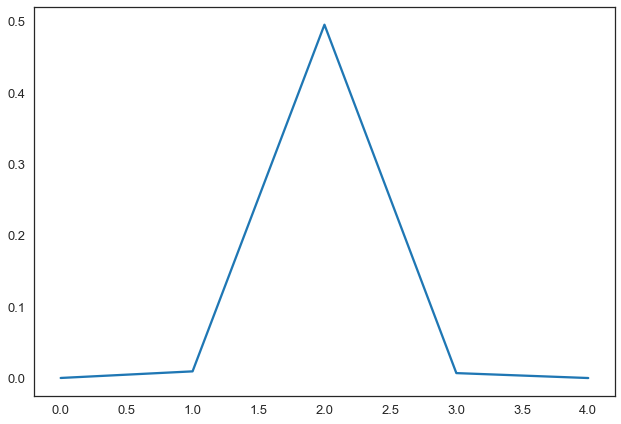

In [7]:
plt.plot(grav_regular)

### centered regular grid

In [8]:
def compute_forward_gravity(tz, densities=None):
    n_devices = tf.math.floordiv((tf.shape(densities)[0]), tf.shape(tz)[0])
    tz_rep = tf.tile(tz, [n_devices])
    grav = tf.reduce_sum(tf.reshape(densities * tz_rep, [n_devices, -1]), axis=1)
    return -grav

def compute_grav_centreg(sphere,center_grid_resolution,radius=[2000,2000,1000]):

  centerReg = CenteredRegGrid(sphere.xy_ravel,radius=radius,resolution=center_grid_resolution)

  g_center_regulargrid = GravityPreprocessing(centerReg)
  tz_center_regulargrid = tfconstant(g_center_regulargrid.set_tz_kernel())

  Z_x = sphere.scalar_field(centerReg.values)

  grav_center_reg = compute_forward_gravity(tz_center_regulargrid,densities = Z_x)
  return grav_center_reg

center_grid_resolution = [20,20,30]
grav_center_reg = compute_grav_centreg(sphere,center_grid_resolution)

### centered ML grid

In [15]:

class Optimizing():
  def __init__(self,center_grid_resolution,radius):

    min_ = -1
    max_ = 1
    self._a = make_variables(tf.cast(center_grid_resolution[0]/2+1,tf.int32),initializer= tf.random_uniform_initializer(minval=min_, maxval=max_, seed=None))
    self._b = make_variables(tf.cast(center_grid_resolution[1]/2+1,tf.int32),initializer= tf.random_uniform_initializer(minval=min_, maxval=max_, seed=None))
    self._c = make_variables(tf.cast(center_grid_resolution[2],tf.int32),initializer= tf.random_uniform_initializer(minval=min_, maxval=max_, seed=None))
  
  def loss(self,a,b,c):
    tz = compute_tz(a,b,c,radius)
    l = tf.math.reduce_std(tz)
    return l

  @tf.function
  def train_step(self,opt):
    with tf.GradientTape() as tape:
      loss_value = self.loss(self._a,self._b,self._c)
      grads = tape.gradient(loss_value,[self._a,self._b,self._c])

    opt.apply_gradients(zip(grads, [self._a,self._b,self._c]))
    return loss_value

  def __call__(self,epochs = 1000):

    opt = tf.keras.optimizers.Adam(
      learning_rate=0.01, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False,
      name='Adam')

    for epoch in range(epochs):
      # start_time = time.time()
      loss_value = self.train_step(opt)
      if epoch%200==0:
        print("\nStart of epoch %d" % (epoch,))
        print("loss: %.10f" % (float(loss_value),))
        # print("Time taken: %.2fs" % (time.time() - start_time))
    
    return self._a,self._b,self._c


class OptimalGrid(CenteredGrid):
    """
    ML optimized spaced grid.
    """

    def __init__(self, centers=None, radius=None, resolution=None, abc = None):
        super().__init__(centers=None, radius=None, resolution=None)
        self.grid_type = 'centered_grid'
        self.values = np.empty((0, 3))
        self.length = self.values.shape[0]
        self.kernel_centers = np.empty((0, 3))
        self.kernel_dxyz_left = np.empty((0, 3))
        self.kernel_dxyz_right = np.empty((0, 3))
        self.tz = np.empty(0)

        if centers is not None and radius  is not None and abc is None:
            # if resolution is None:
            #     resolution = [10, 10, 20]
            
            f = Optimizing(resolution,radius)
            a,b,c = f(epochs=1000)
            self.abc = [a,b,c]

            self.set_centered_grid( centers = centers,radius=radius, resolution=resolution,a=a,b=b,c=c)
        
        # with a given optimized grid
        elif centers is not None and radius  is not None and abc is not None: 
            a, b, c = [abc[i] for i in range(3)]
            self.set_centered_grid( centers = centers,radius=radius, resolution=resolution,a=a,b=b,c=c)

###################



    @staticmethod
    def create_irregular_grid_kernel(resolution, radius,epochs=1000,a=None,b=None,c=None):
        """
        Create an isometric grid kernel (centered at 0)

        Args:
            resolution: [s0]
            radius (float): Maximum distance of the kernel

        Returns:
            tuple: center of the voxel, left edge of each voxel (for xyz), right edge of each voxel (for xyz).
        """
        import copy
        if not isinstance(radius, list) or isinstance(radius, np.ndarray):
            radius = np.repeat(radius, 3)

        # a,b,c = find_optimal_grid(a,b,c,epochs)
   
        g_x = tf.cumsum(softmax_space(a))
        g_y = tf.cumsum(softmax_space(b))
        g_z = tf.cumsum(softmax_space(c))

        g2_x = tf.concat((-g_x[::-1], g_x),axis=0) * radius[0]
        g2_y = tf.concat((-g_y[::-1], g_y),axis=0) * radius[1]
        g2_z =  (tf.concat(([0], g_z),axis=0) + 0.005) * - radius[2]

        x_center = (g2_x[:-1]+g2_x[1:])/2 
        y_center = (g2_y[:-1]+g2_y[1:])/2
        z_center = (g2_z[:-1]+g2_z[1:])/2

        g = tf.meshgrid(x_center,y_center,z_center)

        d_left_x = tf.math.abs(g2_x[:-1] - x_center)
        d_left_y = tf.math.abs(g2_y[:-1] - y_center)
        d_right_x = tf.math.abs(g2_x[1:] - x_center)
        d_right_y = tf.math.abs(g2_y[1:] - y_center)
        d_z = z_center - g2_z[:-1]

        d_left = tf.meshgrid(d_left_x,d_left_y,d_z)
        d_right = tf.meshgrid(d_right_x,d_right_y,d_z)

        kernel_g = tf.concat([tf.reshape(g[0],[-1,1]),tf.reshape(g[1],[-1,1]),tf.reshape(g[2],[-1,1])],axis=1)
        kernel_d_left = tf.concat([tf.reshape(d_left[0],[-1,1]),tf.reshape(d_left[1],[-1,1]),tf.reshape(d_left[2],[-1,1])],axis=1)
        kernel_d_right = tf.concat([tf.reshape(d_right[0],[-1,1]),tf.reshape(d_right[1],[-1,1]),tf.reshape(d_right[2],[-1,1])],axis=1)

        return kernel_g.numpy(), kernel_d_left.numpy(), kernel_d_right.numpy()
  

    def set_centered_kernel(self, resolution, radius,a=None,b=None,c=None):
        """
        Set a centered

        Args:
            resolution: [s0]
            radius (float): Maximum distance of the kernel

        Returns:

        """
        self.kernel_centers, self.kernel_dxyz_left, self.kernel_dxyz_right = self.create_irregular_grid_kernel(
            resolution, radius,a=a,b=b,c=c)

        return self.kernel_centers


# centered optimized grid
def compute_tz(a,b,c,radius):
  g_x = tf.cumsum(softmax_space(a))
  g_y = tf.cumsum(softmax_space(b))
  g_z = tf.cumsum(softmax_space(c))

  g2_x = tf.concat((-g_x[::-1], g_x),axis=0) * radius[0]
  g2_y = tf.concat((-g_y[::-1], g_y),axis=0) * radius[1]
  g2_z =  (tf.concat(([0], g_z),axis=0) + 0.005) * - radius[2]

  x_center = (g2_x[:-1]+g2_x[1:])/2 
  y_center = (g2_y[:-1]+g2_y[1:])/2
  z_center = (g2_z[:-1]+g2_z[1:])/2

  g = tf.meshgrid(x_center,y_center,z_center)

  d_left_x = tf.math.abs(g2_x[:-1] - x_center)
  d_left_y = tf.math.abs(g2_y[:-1] - y_center)
  d_right_x = tf.math.abs(g2_x[1:] - x_center)
  d_right_y = tf.math.abs(g2_y[1:] - y_center)
  d_z = z_center - g2_z[:-1]

  d_left = tf.meshgrid(d_left_x,d_left_y,d_z)
  d_right = tf.meshgrid(d_right_x,d_right_y,d_z)

  kernel_g = tf.concat([tf.reshape(g[0],[-1,1]),tf.reshape(g[1],[-1,1]),tf.reshape(g[2],[-1,1])],axis=1)
  kernel_d_left = tf.concat([tf.reshape(d_left[0],[-1,1]),tf.reshape(d_left[1],[-1,1]),tf.reshape(d_left[2],[-1,1])],axis=1)
  kernel_d_right = tf.concat([tf.reshape(d_right[0],[-1,1]),tf.reshape(d_right[1],[-1,1]),tf.reshape(d_right[2],[-1,1])],axis=1)

  s_gr_x = kernel_g[:, 0]
  s_gr_y = kernel_g[:, 1]
  s_gr_z = kernel_g[:, 2]

  # # getting the coordinates of the corners of the voxel...
  x_cor = tf.transpose(tf.stack([s_gr_x - kernel_d_left[:, 0], s_gr_x + kernel_d_right[:, 0]], axis=0))
  y_cor = tf.transpose(tf.stack((s_gr_y - kernel_d_left[:, 1], s_gr_y + kernel_d_right[:, 1]), axis=0))
  z_cor = tf.transpose(tf.stack((s_gr_z - kernel_d_left[:, 2], s_gr_z + kernel_d_right[:, 2]), axis=0))

  x_matrix = tf.repeat(x_cor, 4, axis=1)
  y_matrix = tf.tile(tf.repeat(y_cor, 2, axis=1), (1, 2))
  z_matrix = tf.tile(z_cor, (1, 4))

  s_r = tf.sqrt(x_matrix ** 2 + y_matrix ** 2 + z_matrix ** 2)

  mu = tfconstant([1, -1, -1, 1, -1, 1, 1, -1])

  G = tfconstant(6.674e-3)

  tz = (
        G *
        tf.reduce_sum(- 1 *
                mu * (
                        x_matrix * tf.math.log(y_matrix + s_r) +
                        y_matrix * tf.math.log(x_matrix + s_r) -
                        z_matrix * tf.math.atan(x_matrix * y_matrix / (z_matrix * s_r))),
                axis=1))
  return tz

In [20]:
centerML = OptimalGrid(sphere.xy_ravel,radius=radius,resolution=center_grid_resolution)
Z_x_ML = sphere.scalar_field(centerML.values)
g_center_ML = GravityPreprocessing(centerML)
tz_center_ML = tf.constant(g_center_ML.set_tz_kernel(),dtype = tf.float32)
grav_center_ML = compute_forward_gravity(tz_center_ML,densities = Z_x_ML)


Start of epoch 0
loss: 0.0214046836

Start of epoch 200
loss: 0.0037597578

Start of epoch 400
loss: 0.0025773328

Start of epoch 600
loss: 0.0024811032

Start of epoch 800
loss: 0.0024795604


In [ ]:
def export(sphere,path=None,Z_x = None):
    if Z_x is None:
        df = pd.DataFrame(data= sphere.geo_data.grid.regular_grid.values/10,columns=["x", "y","z"])
        df['dx'] = sphere.geo_data.grid.regular_grid.dx/10
        df['dy'] = sphere.geo_data.grid.regular_grid.dy/10
        df['dz'] = sphere.geo_data.grid.regular_grid.dz/10
    else:
        df = pd.DataFrame(data= sphere.geo_data.grid.regular_grid.values[np.where(Z_x == 1)]/10,columns=["x", "y","z"])
        df['dx'] = sphere.geo_data.grid.regular_grid.dx/10
        df['dy'] = sphere.geo_data.grid.regular_grid.dy/10
        df['dz'] = sphere.geo_data.grid.regular_grid.dz/10
    df.to_csv(path, header = False, index=False)

    return df
path = './regular_sphere.csv'
df = export(sphere,path,Z_x = Z_x)

In [34]:
centerML.kernel_dxyz_right

array([[400.40894  , 400.1947   ,  -3.5215178],
       [400.40894  , 400.1947   ,  -4.943878 ],
       [400.40894  , 400.1947   ,  -6.458063 ],
       ...,
       [400.40894  , 400.19458  , -21.810974 ],
       [400.40894  , 400.19458  , -22.034058 ],
       [400.40894  , 400.19458  , -22.261536 ]], dtype=float32)

In [32]:
ML_center = tf.squeeze(centerML.values[20*20*30*2:20*20*30*3][tf.where(Z_x_ML[20*20*30*2:20*20*30*3]==1)]).numpy()
numpy.savetxt("foo.csv", ML_center, delimiter=",")

TensorShape([186, 3])

In [29]:
tf.where(Z_x_ML[20*20*30*2:20*20*30*3]==1)

<tf.Tensor: shape=(186, 1), dtype=int64, numpy=
array([[ 7120],
       [ 7121],
       [ 7150],
       [ 7151],
       [ 7152],
       [ 7180],
       [ 7181],
       [ 7182],
       [ 7210],
       [ 7211],
       [ 7212],
       [ 7240],
       [ 7241],
       [ 7720],
       [ 7721],
       [ 7749],
       [ 7750],
       [ 7751],
       [ 7752],
       [ 7753],
       [ 7779],
       [ 7780],
       [ 7781],
       [ 7782],
       [ 7783],
       [ 7809],
       [ 7810],
       [ 7811],
       [ 7812],
       [ 7813],
       [ 7839],
       [ 7840],
       [ 7841],
       [ 7842],
       [ 7843],
       [ 7869],
       [ 7870],
       [ 7871],
       [ 7872],
       [ 7873],
       [ 7900],
       [ 7901],
       [ 8350],
       [ 8351],
       [ 8352],
       [ 8379],
       [ 8380],
       [ 8381],
       [ 8382],
       [ 8383],
       [ 8408],
       [ 8409],
       [ 8410],
       [ 8411],
       [ 8412],
       [ 8413],
       [ 8438],
       [ 8439],
       [ 8440],
       [

In [21]:
Z_x_ML.shape

TensorShape([66150])

In [18]:
def compute_grav_centML(sphere,center_grid_resolution,radius = radius,**kwarg):
  centerML = OptimalGrid(sphere.xy_ravel,radius=radius,resolution=center_grid_resolution,**kwarg)
  Z_x_ML = sphere.scalar_field(centerML.values)
  g_center_ML = GravityPreprocessing(centerML)
  tz_center_ML = tf.constant(g_center_ML.set_tz_kernel(),dtype = tf.float32)
  grav_center_ML = compute_forward_gravity(tz_center_ML,densities = Z_x_ML)
  return grav_center_ML,centerML

grav_center_ML,centerML = compute_grav_centML(sphere,center_grid_resolution,radius = radius)


Start of epoch 0
loss: 0.0171640255

Start of epoch 200
loss: 0.0035435401

Start of epoch 400
loss: 0.0025112384

Start of epoch 600
loss: 0.0024838320

Start of epoch 800
loss: 0.0024801721


## Plotting

In [ ]:
regular_grid_resolution

[100, 100, 40]

In [ ]:
def plot_(receivers,Z_x, regular_grid_resolution,sphere_radius,sphere_position,x_obs,grav_analytical_full,
          grav_regular,grav_center_reg,grav_center_ML,max_error_center_reg = None,max_error_center_ml=None,resolution_list = None,i = None):
  # fig, (ax1, ax2) = plt.subplots(2, 1,figsize = (20,5),sharex=True)

  fig = plt.figure(figsize=(20,8))
  ax1 = fig.add_subplot(2, 6, (1, 3))
  ax2 = fig.add_subplot(2, 6, (7, 9)) 
  ax3 = fig.add_subplot(1, 6, 4)
  if max_error_center_reg is not None:
    ax4 = fig.add_subplot(1, 6, (5,6))
  ax1.plot(x_obs,grav_analytical_full)

  circle1 = plt.Circle((sphere_position[1], sphere_position[2]), sphere_radius, 
                      facecolor='r', edgecolor='k', alpha=0.3)

  ax1.plot(receivers[:,0],grav_regular,'.',label = 'convoloted regular grid') # convoluted regular grid
  ax1.plot(receivers[:,0],grav_center_reg,'.',label = 'center reguar grid') # contered regular grid
  ax1.plot(receivers[:,0], grav_center_ML,'.', label = 'center ML grid')
  ax1.set_ylim(-0.1,1.8)
  ax1.legend()

  ax2.set_aspect('equal')  

  ax2.add_patch(circle1)
  Z_x_tensor = Z_x.numpy().reshape(regular_grid_resolution)
  ax2.imshow(Z_x_tensor[:,int(regular_grid_resolution[1]/2),:].T,cmap=plt.cm.YlGnBu,origin='lower',extent=extent[2:], alpha=.3)
  ax2.set_xlabel('xlabel', fontsize=10)


  circle1 = plt.Circle((sphere_position[1], sphere_position[2]), sphere_radius, 
                      facecolor='r', edgecolor='k', alpha=0.3)
  ax3.add_patch(circle1)
  ax3.imshow(Z_x_tensor[:,int(regular_grid_resolution[1]/2),:].T,cmap=plt.cm.YlGnBu,origin='lower',extent=extent[2:], alpha=.3)
  ax3.set_xlim(4800,5200)
  ax3.set_aspect('equal')  
  plt.tight_layout()

  if max_error_center_reg is not None:
    ax4.plot(resolution_list[:i],max_error_center_reg,label='Centered Regular grid')
    ax4.plot(resolution_list[:i],max_error_center_ml,label = 'ML Grid')
    ax4.set_xlim(resolution_list[0],resolution_list[-1])
    ax4.set_ylabel('Max abs error (mgal)')
    ax4.set_xlabel('Resolution ($xy$)')
    ax4.legend()

# regular_grid_resolution =[100, 100, 40]
# plot_(receivers,full_Z_x, regular_grid_resolution,sphere_radius,sphere_position,x_obs,grav_analytical_full,grav_regular,grav_center_reg,grav_center_ML) 

# Inversion

In [ ]:
center_grid_resolution = [50,50,30]

x_obs = receivers[:,0]
x_obs_ = x_obs - sphere.sphere_position[0]
grav_analytical_obs = grav_analytical(x_obs_, extent[-1] - sphere.sphere_position[2], sphere.sphere_radius, density_difference = 1000)
grav_analytical_obs = tfconstant(grav_analytical_obs)

# parameters, and prior
# radius r N~(r0, 20)
# depth z N~(d0, 50)
# x position N~(x0,100)
# prior mean
r0 = [50]
z_0 = 940
x_0 = 5000
mu = tfconstant([r0[0],x_0,z_0])
p0=tfconstant([x_0, z_0])
prior_mean = tf.concat([r0,p0],axis = 0)
# prior mean
scale_r = 20
scale_x = 100
scale_z = 50
prior_cov = tfconstant([scale_r,scale_x,scale_z])

def joint_log_post(mu):
  prior_dist = tfd.MultivariateNormalDiag(loc= prior_mean, scale_diag=prior_cov)

  # likelihood
  sphere = Sphere_scalerfield(sphere_radius=mu[0],
                            sphere_position=tf.concat([mu[1],5000,mu[2]],axis =0),
                            center_grid_resolution = center_grid_resolution,
                            regular_grid_resolution = [1,1,1],
                            receivers=receivers,
                            radius=radius,
                            dtype = 'float32',
                            extent = extent)
  grav_regular_center = compute_grav_centreg(sphere,sphere.center_grid_resolution)
  likelihood_dist = tfd.MultivariateNormalDiag(loc= grav_analytical_obs, scale_diag=0.005*tf.ones([number_receivers],dtype = tf.float32))

  log_prior = prior_dist.log_prob(mu) 
  log_likelihood = likelihood_dist.log_prob(grav_regular_center)
  log_post = log_prior+log_likelihood
  return log_post

In [ ]:
unnormalized_posterior_log_prob = lambda *args: joint_log_post(*args)
initial_chain_state = mu
num_results = 1000
step_size = 0.5
number_burnin = 0

def gauss_new_state_fn(scale, dtype):
    gauss = tfd.Normal(loc=dtype(0), scale=dtype(scale))
    def _fn(state_parts, seed):
        next_state_parts = []
        part_seeds = tfp.random.split_seed(
        seed, n=len(state_parts), salt='rwmgauss')
        for sp, ps in zip(state_parts, part_seeds):
            next_state_parts.append(sp + gauss.sample(
            sample_shape=sp.shape, seed=ps))
        return next_state_parts
    return _fn

samples_reg, kernel_results = tfp.mcmc.sample_chain(
    num_results=num_results,
    current_state=initial_chain_state,
    kernel=tfp.mcmc.RandomWalkMetropolis(
        target_log_prob_fn=unnormalized_posterior_log_prob,
        new_state_fn=gauss_new_state_fn(scale=step_size, dtype=np.float32)),
    num_burnin_steps=number_burnin,
    num_steps_between_results=0,  # Thinning.
    parallel_iterations=1,
    seed=42)

points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']


/usr/local/lib/python3.7/dist-packages/tensorflow_probability/python/mcmc/sample.py:342: UserWarning: Tracing all kernel results by default is deprecated. Set the `trace_fn` argument to None (the future default value) or an explicit callback that traces the values you are interested in.
  warnings.warn('Tracing all kernel results by default is deprecated. Set '
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/cor

points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index

/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


 Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']


In [ ]:
fig, axes = plt.subplots(1, 3)
fig.set_size_inches(20, 5)
titles = ['radius','x coordinate', 'z coordinate']
pred_mean_reg = np.mean(samples_reg,axis = 0)
for i in range(3):
  ax = axes[i]
  ax.hist(samples_reg[:,i])
  ax.axvline(mu[i],color = 'red',label = 'true')
  ax.axvline(pred_mean_reg[i],color = 'red',linestyle=':',label = 'pred mean')
  ax.set_title(titles[i])

plt.legend()

In [ ]:
def joint_log_post(mu):
  prior_dist = tfd.MultivariateNormalDiag(loc= prior_mean, scale_diag=prior_cov)

  # likelihood
  sphere = Sphere_scalerfield(sphere_radius=mu[0],
                            sphere_position=tf.concat([mu[1],5000,mu[2]],axis =0),
                            center_grid_resolution = center_grid_resolution,
                            regular_grid_resolution = [1,1,1],
                            receivers=receivers,
                            radius=radius,
                            dtype = 'float32',
                            extent = extent)
  grav_regular_center,_= compute_grav_centML(sphere,center_grid_resolution,radius = radius,abc = centerML.abc)
  likelihood_dist = tfd.MultivariateNormalDiag(loc= grav_analytical_obs, scale_diag=0.005*tf.ones([number_receivers],dtype = tf.float32))

  log_prior = prior_dist.log_prob(mu) 
  log_likelihood = likelihood_dist.log_prob(grav_regular_center)
  log_post = log_prior+log_likelihood
  return log_post

In [ ]:
# optimize the grid once
_,centerML = compute_grav_centML(sphere,center_grid_resolution,radius = radius)

In [ ]:
unnormalized_posterior_log_prob = lambda *args: joint_log_post(*args)
initial_chain_state = mu

def gauss_new_state_fn(scale, dtype):
    gauss = tfd.Normal(loc=dtype(0), scale=dtype(scale))
    def _fn(state_parts, seed):
        next_state_parts = []
        part_seeds = tfp.random.split_seed(
        seed, n=len(state_parts), salt='rwmgauss')
        for sp, ps in zip(state_parts, part_seeds):
            next_state_parts.append(sp + gauss.sample(
            sample_shape=sp.shape, seed=ps))
        return next_state_parts
    return _fn

samples_ML, kernel_results = tfp.mcmc.sample_chain(
    num_results=num_results,
    current_state=initial_chain_state,
    kernel=tfp.mcmc.RandomWalkMetropolis(
        target_log_prob_fn=unnormalized_posterior_log_prob,
        new_state_fn=gauss_new_state_fn(scale=step_size, dtype=np.float32)),
    num_burnin_steps=number_burnin,
    num_steps_between_results=0,  # Thinning.
    parallel_iterations=1,
    seed=42)

In [ ]:
fig, axes = plt.subplots(1, 3)
fig.set_size_inches(20, 5)
titles = ['radius','x coordinate', 'z coordinate']
pred_mean_ML = np.mean(samples_ML,axis = 0)
for i in range(3):
  ax = axes[i]
  ax.hist(samples_ML[:,i])
  ax.axvline(mu[i],color = 'red',label = 'true')
  ax.axvline(pred_mean_ML[i],color = 'red',linestyle=':',label = 'pred mean')
  ax.set_title(titles[i])

plt.legend()

points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
[100, 100, 40]

Start of epoch 0
loss: 0.0327950530

Start of epoch 200
loss: 0.0061447569

Start of epoch 400
loss: 0.0039617834

Start of epoch 600
loss: 0.0037460767

Start of epoch 800
loss: 0.0037206893


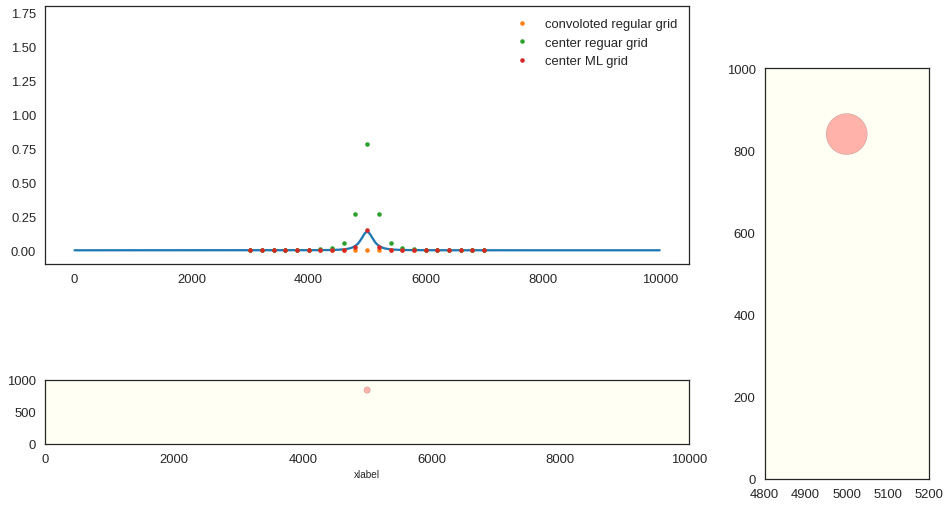

In [ ]:
sphere = Sphere_scalerfield(sphere_radius=mu[0],
                            sphere_position=tf.concat([mu[1],5000,mu[2]],axis =0),
                            center_grid_resolution = center_grid_resolution,
                            regular_grid_resolution = [100,100,40],
                            receivers=receivers,
                            radius=radius,
                            dtype = 'float32',
                            extent = extent)

# analytical solution at 
x_obs_full = np.linspace(extent[2], extent[3], 500)
x_obs_full_ = x_obs_full - sphere.sphere_position[0]
grav_analytical_full = grav_analytical(x_obs_full_, extent[-1] - sphere.sphere_position[2], sphere.sphere_radius, density_difference = 1000)

#analytical solution at receivers
x_obs = receivers[:,0]
x_obs_ = x_obs - sphere.sphere_position[0]
grav_analytical_obs = grav_analytical(x_obs_, extent[-1] - sphere.sphere_position[2], sphere.sphere_radius, density_difference = 1000)


# forward simultation with convoluted regular grid
full_Z_x, grav_regular = compute_grav_conv(sphere)

# forward simulation with cengered regular grid
grav_regular_center = compute_grav_centreg(sphere,center_grid_resolution)

# forward simulation with centered Machine Learning grid
grav_ML_center,_ = compute_grav_centML(sphere,center_grid_resolution,radius = radius)

# plot_(receivers,full_Z_x, regular_grid_resolution,sphere_radius,sphere_position,x_obs,grav_analytical_full,grav_regular,grav_center_reg,grav_center_ML) 
plot_(receivers,full_Z_x, sphere.regular_grid_resolution,sphere.sphere_radius,sphere.sphere_position,x_obs_full,grav_analytical_full,grav_regular,grav_regular_center,grav_ML_center)

# Second sphere

In [ ]:
center_grid_resolution = [20,20,20]

x_obs = receivers[:,0]
x_obs_ = x_obs - sphere.sphere_position[0]
grav_analytical_obs = grav_analytical(x_obs_, extent[-1] - sphere.sphere_position[2], sphere.sphere_radius, density_difference = 1000)
grav_analytical_obs = tfconstant(grav_analytical_obs)

# parameters, and prior
# radius r N~(r0, 20)
# depth z N~(d0, 50)
# x position N~(x0,100)
# prior mean
r0 = [50]
z_0 = 840
x_0 = 5000
mu = tfconstant([r0[0],x_0,z_0])
p0=tfconstant([x_0, z_0])
prior_mean = tf.concat([r0,p0],axis = 0)
# prior mean
scale_r = 20
scale_x = 100
scale_z = 50
prior_cov = tfconstant([scale_r,scale_x,scale_z])

def joint_log_post(mu):
  prior_dist = tfd.MultivariateNormalDiag(loc= prior_mean, scale_diag=prior_cov)

  # likelihood
  sphere = Sphere_scalerfield(sphere_radius=mu[0],
                            sphere_position=tf.concat([mu[1],5000,mu[2]],axis =0),
                            center_grid_resolution = center_grid_resolution,
                            regular_grid_resolution = [1,1,1],
                            receivers=receivers,
                            radius=radius,
                            dtype = 'float32',
                            extent = extent)
  grav_regular_center = compute_grav_centreg(sphere,sphere.center_grid_resolution)
  likelihood_dist = tfd.MultivariateNormalDiag(loc= grav_analytical_obs, scale_diag=0.005*tf.ones([number_receivers],dtype = tf.float32))

  log_prior = prior_dist.log_prob(mu) 
  log_likelihood = likelihood_dist.log_prob(grav_regular_center)
  log_post = log_prior+log_likelihood
  return log_post

In [ ]:
unnormalized_posterior_log_prob = lambda *args: joint_log_post(*args)
initial_chain_state = mu
num_results = 3000
step_size = 0.5
number_burnin = 0

def gauss_new_state_fn(scale, dtype):
    gauss = tfd.Normal(loc=dtype(0), scale=dtype(scale))
    def _fn(state_parts, seed):
        next_state_parts = []
        part_seeds = tfp.random.split_seed(
        seed, n=len(state_parts), salt='rwmgauss')
        for sp, ps in zip(state_parts, part_seeds):
            next_state_parts.append(sp + gauss.sample(
            sample_shape=sp.shape, seed=ps))
        return next_state_parts
    return _fn

samples_reg, kernel_results = tfp.mcmc.sample_chain(
    num_results=num_results,
    current_state=initial_chain_state,
    kernel=tfp.mcmc.RandomWalkMetropolis(
        target_log_prob_fn=unnormalized_posterior_log_prob,
        new_state_fn=gauss_new_state_fn(scale=step_size, dtype=np.float32)),
    num_burnin_steps=number_burnin,
    num_steps_between_results=0,  # Thinning.
    parallel_iterations=1,
    seed=42)

points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')


/usr/local/lib/python3.7/dist-packages/tensorflow_probability/python/mcmc/sample.py:342: UserWarning: Tracing all kernel results by default is deprecated. Set the `trace_fn` argument to None (the future default value) or an explicit callback that traces the values you are interested in.
  warnings.warn('Tracing all kernel results by default is deprecated. Set '
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/cor

Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']


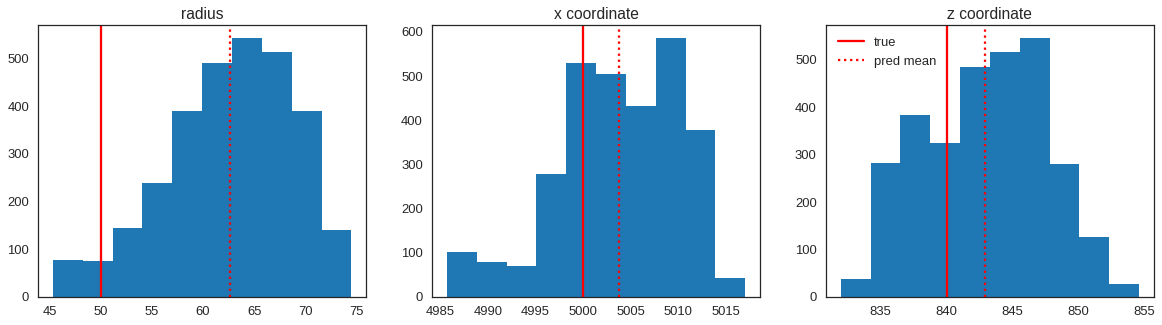

In [ ]:
fig, axes = plt.subplots(1, 3)
fig.set_size_inches(20, 5)
titles = ['radius','x coordinate', 'z coordinate']
pred_mean_reg = np.mean(samples_reg,axis = 0)
for i in range(3):
  ax = axes[i]
  ax.hist(samples_reg[:,i])
  ax.axvline(mu[i],color = 'red',label = 'true')
  ax.axvline(pred_mean_reg[i],color = 'red',linestyle=':',label = 'pred mean')
  ax.set_title(titles[i])

plt.legend()

In [ ]:
def joint_log_post(mu):
  prior_dist = tfd.MultivariateNormalDiag(loc= prior_mean, scale_diag=prior_cov)

  # likelihood
  sphere = Sphere_scalerfield(sphere_radius=mu[0],
                            sphere_position=tf.concat([mu[1],5000,mu[2]],axis =0),
                            center_grid_resolution = center_grid_resolution,
                            regular_grid_resolution = [1,1,1],
                            receivers=receivers,
                            radius=radius,
                            dtype = 'float32',
                            extent = extent)
  grav_regular_center,_= compute_grav_centML(sphere,center_grid_resolution,radius = radius,abc = centerML.abc)
  likelihood_dist = tfd.MultivariateNormalDiag(loc= grav_analytical_obs, scale_diag=0.005*tf.ones([number_receivers],dtype = tf.float32))

  log_prior = prior_dist.log_prob(mu) 
  log_likelihood = likelihood_dist.log_prob(grav_regular_center)
  log_post = log_prior+log_likelihood
  return log_post

In [ ]:
# optimize the grid once
_,centerML = compute_grav_centML(sphere,center_grid_resolution,radius = radius)


Start of epoch 0
loss: 0.0221723858

Start of epoch 200
loss: 0.0050353566

Start of epoch 400
loss: 0.0037287590

Start of epoch 600
loss: 0.0037095603

Start of epoch 800
loss: 0.0037053330


In [ ]:
unnormalized_posterior_log_prob = lambda *args: joint_log_post(*args)
initial_chain_state = mu

def gauss_new_state_fn(scale, dtype):
    gauss = tfd.Normal(loc=dtype(0), scale=dtype(scale))
    def _fn(state_parts, seed):
        next_state_parts = []
        part_seeds = tfp.random.split_seed(
        seed, n=len(state_parts), salt='rwmgauss')
        for sp, ps in zip(state_parts, part_seeds):
            next_state_parts.append(sp + gauss.sample(
            sample_shape=sp.shape, seed=ps))
        return next_state_parts
    return _fn

samples_ML, kernel_results = tfp.mcmc.sample_chain(
    num_results=num_results,
    current_state=initial_chain_state,
    kernel=tfp.mcmc.RandomWalkMetropolis(
        target_log_prob_fn=unnormalized_posterior_log_prob,
        new_state_fn=gauss_new_state_fn(scale=step_size, dtype=np.float32)),
    num_burnin_steps=number_burnin,
    num_steps_between_results=0,  # Thinning.
    parallel_iterations=1,
    seed=42)

points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']


/usr/local/lib/python3.7/dist-packages/tensorflow_probability/python/mcmc/sample.py:342: UserWarning: Tracing all kernel results by default is deprecated. Set the `trace_fn` argument to None (the future default value) or an explicit callback that traces the values you are interested in.
  warnings.warn('Tracing all kernel results by default is deprecated. Set '
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/cor

points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index

/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


 Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: invalid value encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')


In [ ]:
fig, axes = plt.subplots(1, 3)
fig.set_size_inches(20, 5)
titles = ['radius','x coordinate', 'z coordinate']
pred_mean_ML = np.mean(samples_ML,axis = 0)
for i in range(3):
  ax = axes[i]
  ax.hist(samples_ML[:,i])
  ax.axvline(mu[i],color = 'red',label = 'true')
  ax.axvline(pred_mean_ML[i],color = 'red',linestyle=':',label = 'pred mean')
  ax.set_title(titles[i])

plt.legend()

In [ ]:
sphere = Sphere_scalerfield(sphere_radius=mu[0],
                            sphere_position=tf.concat([mu[1],5000,mu[2]],axis =0),
                            center_grid_resolution = center_grid_resolution,
                            regular_grid_resolution = [100,100,40],
                            receivers=receivers,
                            radius=radius,
                            dtype = 'float32',
                            extent = extent)

# analytical solution at 
x_obs_full = np.linspace(extent[2], extent[3], 500)
x_obs_full_ = x_obs_full - sphere.sphere_position[0]
grav_analytical_full = grav_analytical(x_obs_full_, extent[-1] - sphere.sphere_position[2], sphere.sphere_radius, density_difference = 1000)

#analytical solution at receivers
x_obs = receivers[:,0]
x_obs_ = x_obs - sphere.sphere_position[0]
grav_analytical_obs = grav_analytical(x_obs_, extent[-1] - sphere.sphere_position[2], sphere.sphere_radius, density_difference = 1000)


# forward simultation with convoluted regular grid
full_Z_x, grav_regular = compute_grav_conv(sphere)

# forward simulation with cengered regular grid
grav_regular_center = compute_grav_centreg(sphere,center_grid_resolution)

# forward simulation with centered Machine Learning grid
grav_ML_center,_ = compute_grav_centML(sphere,center_grid_resolution,radius = radius)

# plot_(receivers,full_Z_x, regular_grid_resolution,sphere_radius,sphere_position,x_obs,grav_analytical_full,grav_regular,grav_center_reg,grav_center_ML) 
plot_(receivers,full_Z_x, sphere.regular_grid_resolution,sphere.sphere_radius,sphere.sphere_position,x_obs_full,grav_analytical_full,grav_regular,grav_regular_center,grav_ML_center)

# Convergence check

In [ ]:
receivers[:,0].shape

(11,)

In [ ]:
grav_ML_center[1]

points_count.index Int64Index([], dtype='int64')
Active grids: ['regular']
points_count.index Int64Index([], dtype='int64')
points_count.index Int64Index([], dtype='int64')
points_count.index Float64Index([1.0], dtype='float64')


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2468: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_extent = (grid.regular_grid.extent - np.repeat(centers, 2)) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2469: RuntimeWarning: divide by zero encountered in true_divide
  new_grid_values = (grid.values - centers) / rescaling_factor + 0.5001
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:141: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']))
/content/drive/My Drive/YJ/GP_old/gempy/core/interpolator.py:146: RuntimeWarning: invalid value encountered in double_scalars
  'values', 'rescaling factor']


points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Float64Index([1.0], dtype='float64')
points_count.index Int64Index([1], dtype='int64')
points_count.index Int64Index([1], dtype='int64')
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
[100, 100, 40]

Start of epoch 0
loss: 0.0047804471

Start of epoch 200
loss: 0.0008575903

Start of epoch 400
loss: 0.0005146213

Start of epoch 600
loss: 0.0004992260

Start of epoch 800
loss: 0.0004971584


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


ValueError: ignored

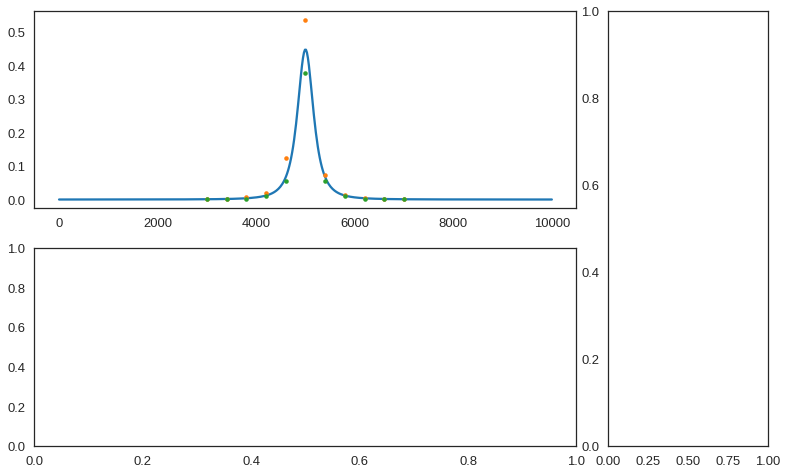

In [ ]:
sphere = Sphere_scalerfield(sphere_radius=sphere_radius,
                          sphere_position=sphere_position,
                          center_grid_resolution = center_grid_resolution,
                          regular_grid_resolution = regular_grid_resolution,
                          receivers=receivers,
                          radius=radius,
                          dtype = 'float32',
                          extent = extent)

def evaluate(sphere,extent,radius,**kwargs):

  # analytical solution at 
  x_obs_full = np.linspace(extent[2], extent[3], 500)
  x_obs_full_ = x_obs_full - sphere.sphere_position[0]
  grav_analytical_full = grav_analytical(x_obs_full_, extent[-1] - sphere.sphere_position[2], sphere.sphere_radius, density_difference = 1000)

  #analytical solution at receivers
  x_obs = receivers[:,0]
  x_obs_ = x_obs - sphere.sphere_position[0]
  grav_analytical_obs = grav_analytical(x_obs_, extent[-1] - sphere.sphere_position[2], sphere.sphere_radius, density_difference = 1000)


  # forward simultation with convoluted regular grid
  full_Z_x, grav_regular = compute_grav_conv(sphere)

  # forward simulation with cengered regular grid
  grav_regular_center = compute_grav_centreg(sphere,sphere.center_grid_resolution)

  # forward simulation with centered Machine Learning grid
  grav_ML_center,_ = compute_grav_centML(sphere,sphere.center_grid_resolution,radius = radius)

  plot_(full_Z_x, sphere.regular_grid_resolution,sphere.sphere_radius,sphere.sphere_position,x_obs_full,grav_analytical_full,grav_regular,grav_regular_center,grav_ML_center,**kwargs)
  print('kernel resolution:',sphere.regular_grid_resolution,sphere.center_grid_resolution)
  print('RMSE Convoluted regular grid: ', np.sqrt(np.mean((grav_analytical_obs -grav_regular)**2)))
  print('RMSE Centered regular grid:', np.sqrt(np.mean((grav_analytical_obs -grav_regular_center)**2)))
  print('RMSE centered ML grid:', np.sqrt(np.mean((grav_analytical_obs -grav_ML_center)**2)))


  return grav_analytical_full,grav_analytical_obs,grav_regular,grav_regular_center,grav_ML_center

grav_analytical_full,grav_analytical_obs,grav_regular,grav_regular_center,grav_ML_center = evaluate(sphere,extent,radius)

In [ ]:
max_error_center_reg = []
max_error_center_ml = []
resolution_list = np.arange(5,100,2)
for i in range(resolution_list.shape[0]):
# for n in resolution_list:
  n = resolution_list[i]
  sphere_radius = 100
  sphere_position = [5000, 5000, 870]
  center_grid_resolution = [n,n,30]
  # regular_grid_resolution = [int(2.5*n),100,30]
  regular_grid_resolution = [100,100,30]
  sphere = Sphere_scalerfield(sphere_radius=sphere_radius,
                            sphere_position=sphere_position,
                            center_grid_resolution = center_grid_resolution,
                            regular_grid_resolution = regular_grid_resolution,
                            receivers=receivers,
                            radius=radius,
                            dtype = 'float64',
                            extent = extent)
  grav_analytical_full,grav_analytical_obs,grav_regular,grav_regular_center,grav_ML_center = evaluate(sphere,extent,radius,
                                                                                                      max_error_center_reg = max_error_center_reg,
                                                                                                      max_error_center_ml=max_error_center_ml,
                                                                                                      resolution_list = resolution_list,
                                                                                                      i = i)
  max_error_center_reg.append(np.max(np.abs(grav_regular_center - grav_analytical_obs)))
  max_error_center_ml.append(np.max(np.abs(grav_ML_center - grav_analytical_obs)))
